# Final Review

In [1]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import grad, random
from mpl_toolkits.mplot3d import Axes3D
from itertools import product

In [2]:
%config InlineBackend.figure_format = "retina"

## The Bregman Proximal method


Formulate the Bregman proximal method given a function $E:\mathbb{R}^N \to \mathbb{R}$ for the choice 

$$
    J({\bf x}) = \frac{1}{\tau}\sum_{j=1}^N\left[(1-x_n)\log(1-x_n) + x_n \log(x_n) -1 \right]
$$


The Bregman distance for the given choice $J$ is given by

$$
    D_J({\bf u}, {\bf v}) = \sum_{n=1}^N u_n \left[ \log\left(\frac{u_n}{v_n}\right) + (1 - u_n) \log\left(\frac{1-u_n}{1-v_n}\right) \right]
$$

In [3]:
key = random.PRNGKey(0)
x, y = jnp.abs(random.beta(key, 2, 4, (2, 15)))
x

array([0.6010489 , 0.4508557 , 0.35213393, 0.02290265, 0.69061667,
       0.48838946, 0.44977003, 0.7096753 , 0.85323936, 0.19534549,
       0.45806506, 0.3516461 , 0.21225834, 0.45255467, 0.19804347],
      dtype=float32)

In [4]:
def J(x, τ=1):
    v =  1/τ * ((1 - x) * jnp.log(1 - x) + x * jnp.log(x)) - 1
    return jnp.sum(v)

def dxJ_exact(x, τ=1):
    return 1/τ * jnp.log(x / (1 - x))

dxJ = grad(J)

In [5]:
dxJ(x)

DeviceArray([ 0.40983742, -0.19721389, -0.6096724 , -3.7533333 ,
              0.8030039 , -0.0464505 , -0.2015999 ,  0.89380765,
              1.7602372 , -1.4156432 , -0.16813481, -0.61181146,
             -1.3113661 , -0.19035393, -1.3985679 ], dtype=float32)

In [6]:
dxJ_exact(x)

DeviceArray([ 0.40983737, -0.19721383, -0.60967237, -3.7533333 ,
              0.80300385, -0.04645047, -0.2015999 ,  0.89380765,
              1.7602372 , -1.4156432 , -0.16813473, -0.6118114 ,
             -1.3113661 , -0.19035396, -1.3985679 ], dtype=float32)

In [7]:
def bregman_bern_exact(u, v, τ=1):
    """
    Compute the exact bregman distance for with respect
    to the the bernoulli log-likelihood minus N
    """
    res = 1 / τ * (u * jnp.log(u / v) + (1 - u) * jnp.log((1 - u) / (1 - v)))
    return jnp.sum(res)


def bregman(u, v, J):
    """
    Generalized Bregman distance for arbitrary,
    differentiable, and convex choice of J
    """
    dxJ = grad(J)
    return J(u) - J(v) - dxJ(v) @ (u - v)

In [8]:
bregman_bern_exact(x, y, 0.4)

DeviceArray(7.044682, dtype=float32)

In [9]:
bregman(x, y, lambda u: J(u, 0.4))

DeviceArray(7.0446863, dtype=float32)

### Comparing the asymmetry

In [10]:
bregman(x, y, J)

DeviceArray(2.817871, dtype=float32)

In [11]:
bregman(y, x, J)

DeviceArray(3.3040211, dtype=float32)

## Perceptron algorithm

You want to decide whether or not to self-isolate for two weeks. You base your decision based on three factors:

1. Do I have covid-19 symptoms?
2. Do any of the people I live with have been diagnosed with covid-19?
3. Does a dodgy covid-19 test bought from an unofficial source indicates infection?

Suppose you do not bother self-isolating even if the test turns positive. However, you do self-isolate if you show sumptoms or one of the people you live with has been diagnosed with covid-19.

Model this binary decision process with a perceptron and choose some appropriate weights to mimic the decision process accurately.

In [12]:
X = np.array([v for v in product(*([0, 1], ) * 3)])
X

array([[0, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 1],
       [1, 0, 0],
       [1, 0, 1],
       [1, 1, 0],
       [1, 1, 1]])

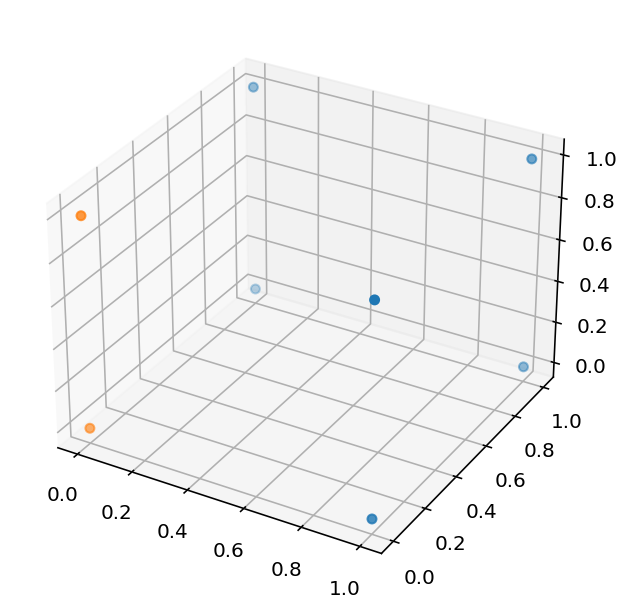

In [13]:
# Visually check whether the dataset is linearly separable
y = np.array([0, 0, 1, 1, 1, 1, 1, 1])

colors = ["tab:blue" if yn == 1 else "tab:orange" for yn in y]
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(*X.T, c=colors);

In [14]:
def heaviside(a): return 1 * (a >= 0)

def perceptron(X, y, nits=200, r=1):
    N, M = X.shape
    w = np.zeros(M)
    for n in range(nits):
        for xn, yn in zip(X, y):
            yn_hat = heaviside(xn @ w)
            w = w + r * (yn - yn_hat) * xn
    return w

In [15]:
Phi = np.c_[np.ones(8), X]
w_perceptron = perceptron(Phi, y)
w_perceptron

array([-1.,  1.,  1.,  0.])

In [16]:
Phi @ w_perceptron

array([-1., -1.,  0.,  0.,  0.,  0.,  1.,  1.])

In [17]:
# Check that we recover the intended datapoints
heaviside(Phi @ w_perceptron)

array([0, 0, 1, 1, 1, 1, 1, 1])

## K-means (by hand)

In [18]:
from sklearn.preprocessing import OneHotEncoder
%precision 2

'%.2f'

In [19]:
n_clusters = 3
classes = np.arange(n_clusters)
ohe = OneHotEncoder(categories=[classes], sparse=False)

In [20]:
d = 8
x = np.array([-20, 3, 15, -7, -16, 1, 21])
mu = np.array([d, -d, 0])

#### First Iteration

In [21]:
distances = np.abs(x[:, None] - mu)
distances

array([[28, 12, 20],
       [ 5, 11,  3],
       [ 7, 23, 15],
       [15,  1,  7],
       [24,  8, 16],
       [ 7,  9,  1],
       [13, 29, 21]])

In [22]:
# E-step: classify
e_step = distances.argmin(axis=1)
e_step

array([1, 2, 0, 1, 1, 2, 0])

In [23]:
# M-step: update
mu = ohe.fit_transform(e_step[:, None])
mu = (x[:, None] * mu).sum(axis=0) / mu.sum(axis=0)
mu

array([ 18.  , -14.33,   2.  ])

#### Second Iteration

In [24]:
distances = np.abs(x[:, None] - mu)
distances

array([[38.  ,  5.67, 22.  ],
       [15.  , 17.33,  1.  ],
       [ 3.  , 29.33, 13.  ],
       [25.  ,  7.33,  9.  ],
       [34.  ,  1.67, 18.  ],
       [17.  , 15.33,  1.  ],
       [ 3.  , 35.33, 19.  ]])

In [25]:
# E-step: classify
e_step = distances.argmin(axis=1)
e_step

array([1, 2, 0, 1, 1, 2, 0])

In [26]:
# M-step: update
mu = ohe.fit_transform(e_step[:, None])
mu = (x[:, None] * mu).sum(axis=0) / mu.sum(axis=0)
mu

array([ 18.  , -14.33,   2.  ])

#### Third Iteration

In [27]:
distances = np.abs(x[:, None] - mu)
distances

array([[38.  ,  5.67, 22.  ],
       [15.  , 17.33,  1.  ],
       [ 3.  , 29.33, 13.  ],
       [25.  ,  7.33,  9.  ],
       [34.  ,  1.67, 18.  ],
       [17.  , 15.33,  1.  ],
       [ 3.  , 35.33, 19.  ]])

In [28]:
# E-step: classify
distances.argmin(axis=1)

array([1, 2, 0, 1, 1, 2, 0])

In [29]:
# M-step: update
mu = ohe.fit_transform(e_step[:, None])
mu = (x[:, None] * mu).sum(axis=0) / mu.sum(axis=0)
mu

array([ 18.  , -14.33,   2.  ])

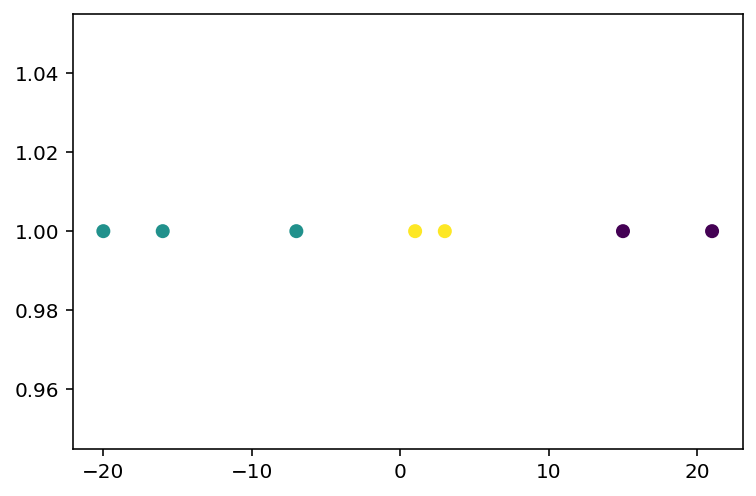

In [30]:
plt.scatter(x, np.ones_like(x), c=e_step)

#### Check against sklearn

In [31]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, init=np.array([[-d, d, 0]]).T, n_init=1)
kmeans.fit(x[:, None])
kmeans.cluster_centers_

array([[-14.33],
       [ 18.  ],
       [  2.  ]])

## Singular Value Decomposition (SVD)

In [32]:
X = np.array([
    [1, 3],
    [3, 1]
])

In [33]:
X = np.array([
    [-2, 3, 2],
    [2, 2, 3]
])

In [34]:
X = np.array([
    [3, 2, 2],
    [2, 3, -2]
])

U, s, Vt = np.linalg.svd(X)
s

array([5., 3.])

In [35]:
X.shape

(2, 3)

In [36]:
U, s, Vt = np.linalg.svd(X)
Σ = np.zeros_like(X, dtype=np.float)
Σ[np.diag_indices(2)] = s
U @ Σ @ Vt

array([[ 3.,  2.,  2.],
       [ 2.,  3., -2.]])

In [37]:
np.linalg.eig(X @ X.T)

(array([25.,  9.]),
 array([[ 0.71, -0.71],
        [ 0.71,  0.71]]))

## Question 3 (mock exam 2020)

In [43]:
names = np.array(["Batman", "Catwoman", "Wonder Woman", "Jessica Jones", "Deadpool", "Spiderman"])
len(names)

6

In [49]:
for i, name in enumerate(sorted(names)):
    print(i+1, name)

1 Batman
2 Catwoman
3 Deadpool
4 Jessica Jones
5 Spiderman
6 Wonder Woman


In [119]:
w = np.array([4, 81, 16, 64, 64, 36, 49, 49, 1, 49, 1])
np.sqrt(w)

array([2., 9., 4., 8., 8., 6., 7., 7., 1., 7., 1.])

In [120]:
edges = np.array([
    [1, 4],
    [1, 2],
    [1, 3],
    [1, 6],
    [4, 3],
    [4, 6],
    [4, 5],
    [2, 6],
    [2, 5],
    [3, 5],
    [6, 5]
]) - 1

edges = np.sort(edges, axis=1)
edges.shape

(11, 2)

In [121]:
n_nodes = len(np.unique(edges))
n_edges = len(w)

In [122]:
Mw = np.zeros((n_edges, n_nodes))
for i, (wn, (e1, e2)) in enumerate(zip(w, edges)):
    Mw[i, e1] = - np.sqrt(wn)
    Mw[i, e2] = np.sqrt(wn)

Mw

array([[-2.,  0.,  0.,  2.,  0.,  0.],
       [-9.,  9.,  0.,  0.,  0.,  0.],
       [-4.,  0.,  4.,  0.,  0.,  0.],
       [-8.,  0.,  0.,  0.,  0.,  8.],
       [ 0.,  0., -8.,  8.,  0.,  0.],
       [ 0.,  0.,  0., -6.,  0.,  6.],
       [ 0.,  0.,  0., -7.,  7.,  0.],
       [ 0., -7.,  0.,  0.,  0.,  7.],
       [ 0., -1.,  0.,  0.,  1.,  0.],
       [ 0.,  0., -7.,  0.,  7.,  0.],
       [ 0.,  0.,  0.,  0., -1.,  1.]])

In [123]:
Mw.shape

(11, 6)

In [127]:
Lw = Mw.T @ Mw
Lw

array([[165., -81., -16.,  -4.,   0., -64.],
       [-81., 131.,   0.,   0.,  -1., -49.],
       [-16.,   0., 129., -64., -49.,   0.],
       [ -4.,   0., -64., 153., -49., -36.],
       [  0.,  -1., -49., -49., 100.,  -1.],
       [-64., -49.,   0., -36.,  -1., 150.]])

In [180]:
known = np.array([3, 1]) - 1
y = np.array([0, 1])

PR = np.zeros((known.shape[0], n_nodes))
PR_perp = np.zeros((n_nodes - known.shape[0], n_nodes))

PR[[0,1], known] = 1

PR_perp[[0,1,2,3], [1,3,4,5]] = 1

We assign the new classes with

$$
    \left({\bf P}_{R\perp} {\bf L}_{\bf w} {\bf P}_{R\perp}^T \right) \tilde {\boldsymbol u} = -{\bf P}_{R\perp} {\bf L}_{\bf w}^T {\bf P}_{R}^T {\bf y}
$$

Where $\tilde{\boldsymbol u} = {\bf P}_{R\perp} \hat{\boldsymbol u}$; $\hat{\boldsymbol u}$ is the array of unkown labels.

In [220]:
np.linalg.inv(PR_perp @ Lw @ PR_perp.T)

array([[0.01, 0.  , 0.  , 0.  ],
       [0.  , 0.01, 0.  , 0.  ],
       [0.  , 0.  , 0.01, 0.  ],
       [0.  , 0.  , 0.  , 0.01]])

In [219]:
-PR_perp @ Lw.T @ PR.T @ y

array([81.,  4.,  0., 64.])

In [204]:
labels = PR_perp.T @ (-np.linalg.inv(PR_perp @ Lw @ PR_perp.T) @ PR_perp @ Lw.T @ PR.T @ y)
labels[known] = y
labels

array([1.  , 0.91, 0.  , 0.26, 0.14, 0.79])

In [206]:
classes = labels > 0.5
labels[classes]

array([1.  , 0.91, 0.79])

In [213]:
np.sort(names)[classes]

array(['Batman', 'Catwoman', 'Wonder Woman'], dtype='<U13')

In [214]:
np.sort(names)[~classes]

array(['Deadpool', 'Jessica Jones', 'Spiderman'], dtype='<U13')